The purpose of this exercise is to demonstrate the use of RNNs using generated data. By generating data ourselves, we have more control over what we train and test the model on.


In [1]:
import keras as K
import numpy as np
import pandas as pd

from random import randint, random
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.recurrent import LSTM, SimpleRNN
from keras import optimizers

from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pylab as plt


Using TensorFlow backend.


# Types of Cats

Cats are lazy. They do only one thing every hour. There exists several types of cats. 

Testing that RNN's are capable of performing sequence prediction over different kinds of sequences.

In [2]:
# Most cats perform one of four actions
EAT = 0
NAP = 1
SCRATCH = 2 
BEAT_UP_STINKY_DOG = 3

NUM_POSSIBLE_NORMAL_ACTIONS = 4
NUM_POSSIBLE_ACTIONS = 5

In [3]:
def next_action_round_robin(current_action): 
    return (current_action + 1) % NUM_POSSIBLE_NORMAL_ACTIONS

def random_action(): 
    return randint(0, NUM_POSSIBLE_NORMAL_ACTIONS - 1)

In [4]:
# Predictable Cat behaves in a round robin fashion. Robin... how ironic. 
def predictable_cat():
    action = random_action()
    while True: 
        yield action
        action = next_action_round_robin(action)

In [5]:
# OCD Cat does everything in threes, no more, no less...
def ocd_cat(): 
    action = random_action()
    while True: 
        yield action
        yield action
        yield action
        action = next_action_round_robin(action)

In [6]:
# Unpredictable cat performs a random action sometimes, and resumes the sequence from there
# This adds some noise to our data, the RNN seems robust to that based on accuracy score. 
# On hindsight, should have tagged the cats to check which ones get misclassified.
def unpredictable_cat():
    action = random_action()
    while True:
        action = next_action_round_robin(action) if random() < 0.5 else random_action()
        yield action

In [7]:
# Smelly Cat raids the dumpster every other action
RAID_DUMPSTER = 4

def smelly_cat():
    action = random_action()
    while True:
        yield action
        yield RAID_DUMPSTER
        action = next_action_round_robin(action)

In [8]:
# Let's have a look at Smelly Cat's day
cat = smelly_cat()
smelly_actions = [next(cat) for i in range(0,20)]
print(smelly_actions)

[1, 4, 2, 4, 3, 4, 0, 4, 1, 4, 2, 4, 3, 4, 0, 4, 1, 4, 2, 4]


In [9]:
def cat_randomizer(with_noise = False):
    cat_gens = [predictable_cat, ocd_cat, smelly_cat]
    if with_noise:
        cat_gens += [unpredictable_cat]

    while True:
        yield cat_gens[randint(0, len(cat_gens) - 1)]()

In [10]:
def actions_for(cat, num_actions):
    return [next(cat) for i in range(0, num_actions)]

# Data Preparation

We will use one-hot encoding to represent actions.

In [11]:
def one_hot(labels, num_classes): 
    return [[1 if i == label else 0 for i in range(0, num_classes)] for label in labels]

In [12]:
one_hot(smelly_actions, NUM_POSSIBLE_ACTIONS)

[[0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1]]

And now for some kitty action!

In [13]:
def bring_me_some_cats(cat_count):
    rand_cat = cat_randomizer(True)
    for i in range(0, cat_count):
        yield next(rand_cat)

In [14]:
num_actions = 51
num_cats = 500
kitties_actions = [one_hot(actions_for(cat, num_actions), NUM_POSSIBLE_ACTIONS) for cat in bring_me_some_cats(num_cats)]

Splice out the last action, this is the "label" that we want to predict.

In [15]:
X = kitties_initial_actions = [k[:num_actions - 1] for k in kitties_actions]
y = kitties_last_action = [k[-1] for k in kitties_actions]

In [16]:
one_hot(smelly_actions, NUM_POSSIBLE_ACTIONS)

[[0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1],
 [0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1]]

And now for some kitty action!

In [17]:
def bring_me_some_cats(cat_count):
    rand_cat = cat_randomizer()
    for i in range(0, cat_count):
        yield next(rand_cat)

In [18]:
num_actions = 51
num_cats = 500
kitties_actions = [one_hot(actions_for(cat, num_actions), NUM_POSSIBLE_ACTIONS) for cat in bring_me_some_cats(num_cats)]

In [19]:
def plot_kitty_actions(actions): #punintended
    actions_decoded = np.argmax(actions, axis=2)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.imshow(actions_decoded, interpolation='nearest', cmap=plt.cm.magma)
    plt.colorbar()
    plt.show()

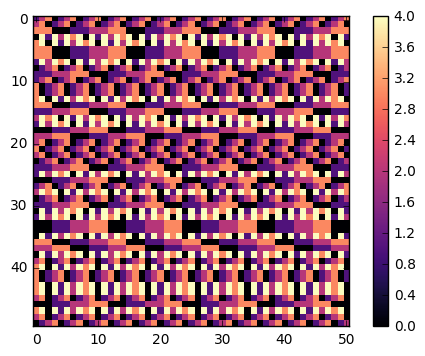

In [20]:
plot_kitty_actions(kitties_actions[:50])

Splice out the last action, this is the "label" that we want to predict.

In [21]:
X = kitties_initial_actions = [k[:num_actions - 1] for k in kitties_actions]
y = kitties_last_action = [k[-1] for k in kitties_actions]

Split the data set into a training set and test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Construct Model

## Model Hyperparameters

In [23]:
EPOCHS = 120
HIDDEN = 10

In [24]:
model = Sequential()
model.add(SimpleRNN(HIDDEN, input_shape=[50, 5]))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, epochs=EPOCHS, batch_size=100)

Epoch 1/120
375/375 [==============================] - 0s - loss: 1.8830 - acc: 0.1573     
Epoch 2/120
375/375 [==============================] - 0s - loss: 1.8287 - acc: 0.1573     
Epoch 3/120
375/375 [==============================] - 0s - loss: 1.7749 - acc: 0.1573     
Epoch 4/120
375/375 [==============================] - 0s - loss: 1.7269 - acc: 0.1573     
Epoch 5/120
375/375 [==============================] - 0s - loss: 1.6812 - acc: 0.1573     
Epoch 6/120
375/375 [==============================] - 0s - loss: 1.6396 - acc: 0.2693     
Epoch 7/120
375/375 [==============================] - 0s - loss: 1.6010 - acc: 0.3200     
Epoch 8/120
375/375 [==============================] - 0s - loss: 1.5651 - acc: 0.3707     
Epoch 9/120
375/375 [==============================] - 0s - loss: 1.5333 - acc: 0.4053     
Epoch 10/120
375/375 [==============================] - 0s - loss: 1.5038 - acc: 0.4053     
Epoch 11/120
375/375 [==============================] - 0s - loss: 1.4791 - acc

# Model Evaluation

In [26]:
def label_from_vector(v): 
    return np.argmax(v)

In [27]:
y_predicted = model.predict(X_test)
y_predicted[:3]

array([[ 0.04020264,  0.06491155,  0.79880697,  0.07932872,  0.01675008],
       [ 0.10174742,  0.01105226,  0.17790852,  0.66927785,  0.040014  ],
       [ 0.00997688,  0.91454339,  0.06265557,  0.0088189 ,  0.00400524]], dtype=float32)

In [28]:
actual_labels = [label_from_vector(yt) for yt in y_test]
predicted_labels = [label_from_vector(yp) for yp in y_predicted]

In [29]:
confusion_matrix(actual_labels, predicted_labels)

array([[33,  0,  0,  0],
       [ 0, 27,  0,  0],
       [ 0,  0, 32,  0],
       [ 0,  0,  0, 33]])

In [30]:
f1_score(actual_labels, predicted_labels, average='macro')

1.0

# Sometimes, cats' behaviors depend on the weather

The purpose of this section is (still unrealized) two-fold. 
1) Show the effectiveness on LSTMs on tasks that RNN's cannot handle (long sequences where associations are separated far in time),
2) Incorporate an input (weather) at each time step and in combination with past history, make a prediction.

Note: I have tried varying the data some ways, but have not yet found a case where LSTMs outperform simple RNN's. 

In [31]:
SUNNY = 0
RAINY = 1    

In [32]:
def sunny_rainy_sunny(rainy_period_start, rainy_duration):
    for i in range(0, rainy_period_start):
        yield SUNNY
    for i in range(0, rainy_duration):
        yield RAINY
    while True: 
        yield SUNNY

In [33]:
def rain_cat(weather):
    action = random_action()
    while True:
        if next(weather) == RAINY: 
            yield NAP
        else:
            yield action
            action = next_action_round_robin(action)

In [74]:
import functools

def random_weather_sequence():
    rain_start = randint(30, 40) # grow and shrink the window size and see how the LSTM responds
    srs = sunny_rainy_sunny(rain_start, num_actions - rain_start - 1)
    return srs

rain_cats = [rain_cat(random_weather_sequence()) for i in range(250)]
rain_cats_actions = [one_hot(actions_for(cat, num_actions), NUM_POSSIBLE_NORMAL_ACTIONS) for cat in rain_cats]


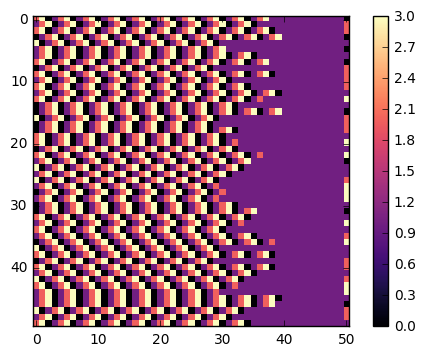

In [75]:
plot_kitty_actions(rain_cats_actions[:50])

In [76]:
X = rain_cats_initial_actions = [k[:num_actions - 1] for k in rain_cats_actions]
y = rain_cats_last_action = [k[-1] for k in rain_cats_actions]

Split the data set into a training set and test set.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# Construct Model

## Model Hyperparameters & Construction

In [78]:
EPOCHS = 250
HIDDEN = 20

In [79]:
def build_model(type):
    model = Sequential()
    input_shape = [num_actions - 1, NUM_POSSIBLE_NORMAL_ACTIONS]
    
    if type == "simple":
        model.add(SimpleRNN(HIDDEN, input_shape=input_shape, activation="relu", recurrent_initializer="random_uniform"))
    elif type == "LSTM":
        model.add(LSTM(HIDDEN, input_shape=input_shape, activation="relu", recurrent_activation="sigmoid", recurrent_initializer="random_uniform"))
    elif type == "LSTM64":
        model.add(LSTM(64, input_dim=64, input_length=10, return_sequences=True))
    else:
        raise Error("invalid layer type")
        
    opt = optimizers.Adam(clipvalue=1.0, lr=0.003, decay=0.02) 
    model.add(Dense(NUM_POSSIBLE_NORMAL_ACTIONS, activation='softmax'))
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [80]:
def train(model, X_train, y_train):
    model.fit(X_train, y_train, epochs=EPOCHS, batch_size=100)

In [81]:
def evaluate(model, X_test, y_test):
    y_predicted = model.predict(X_test)
    actual_labels = [np.argmax(yt) for yt in y_test]
    predicted_labels = [np.argmax(yp) for yp in y_predicted]
    conf_matrix = confusion_matrix(actual_labels, predicted_labels)
    score = f1_score(actual_labels, predicted_labels, average='macro')
    print(conf_matrix)
    print(score)

# Model Comparison

In [82]:
def train_and_eval(type):
    K.backend.clear_session()  # learning rate is practically zero if re-running LSTM without this
    print("Evaluating {}".format(type))
    model = build_model(type)
    train(model, X_train, y_train)
    evaluate(model, X_test, y_test)

In [ ]:
train_and_eval("simple")

Evaluating simple
Epoch 1/250
187/187 [==============================] - 0s - loss: 1.4041 - acc: 0.2727     
Epoch 2/250
187/187 [==============================] - 0s - loss: 1.3938 - acc: 0.2727     
Epoch 3/250
187/187 [==============================] - 0s - loss: 1.3849 - acc: 0.2727     
Epoch 4/250
187/187 [==============================] - 0s - loss: 1.3786 - acc: 0.2727     
Epoch 5/250
187/187 [==============================] - 0s - loss: 1.3739 - acc: 0.2727     
Epoch 6/250
187/187 [==============================] - 0s - loss: 1.3717 - acc: 0.2727     
Epoch 7/250
187/187 [==============================] - 0s - loss: 1.3684 - acc: 0.3209     
Epoch 8/250
187/187 [==============================] - 0s - loss: 1.3673 - acc: 0.3209     
Epoch 9/250
187/187 [==============================] - 0s - loss: 1.3667 - acc: 0.3209     
Epoch 10/250
187/187 [==============================] - 0s - loss: 1.3666 - acc: 0.3209     
Epoch 11/250
187/187 [==============================] - 0s - 

In [ ]:
train_and_eval("LSTM")